This notebook contains the code developed for the Master’s thesis titled "Large Language Models in Applied Qualitative Research: A Structured Pipeline for Automated Thematic Analysis and Model Evaluation". The goal of the project is to explore how large language models (LLMs) can support or automate parts of the inductive thematic analysis process, particularly when working with transcribed audio feedback.

Author: Mélanie Bigler

May 2025

# Step 0: Preparing Data & Environment


In this preparatory step, we load the data and all required computational resources. Each transcript must be of manageable length for an LLM to process effectively. We also define key contextual variables that shape the analysis resp. the prompts to LLMs later , such as role-specific information and language settings.

**Activities:**

-	Load and preprocess transcript data: The transcripts should ideally not exceed 1,500 words per chunk to ensure contextual coherence within the LLM’s input limit (Raza et al., 2025). For Voicy transcripts, this is naturally ensured since each entry typically contains a single Q&A pair.
-	Load necessary Python libraries, prepare models and LLM APIs.
-	Define relevant context variables:
    - Reflectors: the role or perspective (e.g., "manager", "team member")
    - Organisation: the organization name or context
    - Goal: purpose or research objective
    - Input_language: original language (e.g., "german")
    - Output_language: desired output language (e.g., "english")

**Output:**

An initialized environment with structured transcripts, required libraries, and contextual variables prepared for LLM processing.

In [ ]:
# Standard libraries
import json
import re
from collections import Counter
from typing import List, Literal

# Data analysis and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and clustering
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from umap import UMAP
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

# API clients for LLM request (example openai)
from openai import OpenAI

# Data validation and typing (for JSON schemas)
from pydantic import BaseModel, Field

In [ ]:
# Prepare LLM client
client = OpenAI(api_key="key")

In [ ]:
# Prepare Sentence Embedding Model
model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')

def instruct_prompt(text: str, task: str) -> str:
    return f"Instruct: {task} Query: {text}"

## Define Context Variables


In [ ]:
reflectors = "role"
organisation = "company"
goal = "goal of the research"
input_language = "german"
output_language = "english"

## Data Structure

In this use case, the data is organized as a DataFrame in which each row represents a question and the corresponding answer from one participant. Step 1 of the pipeline—initial coding and attribute assignment—is applied individually to each of these question-answer pairs.

In [ ]:
#example entry
data.head(1)

,Survey_ID,Person_ID,Response_ID,Date,Question,Answer
0,5b1c9a83-97d4-42b8-ab53-21130be446cb,1,e4717150-21ff-444e-8bef-39909273e5b8,2024-11-29,Welche Momente in diesem Jahr haben bei dir ei...,Wenn ich über das letzte Jahr nachdenke und am...


# Step 1: Initial Coding and Attributes

Each transcript segment is sent to the LLM for open-ended, inductive coding. The model identifies meaningful statements, assigns an initial code, provides a description, and classifies the excerpt along two dimensions: reflective category and level of reference.

**Activities:**

-	Prepare the LLM request with JSON Schema for reliable feedback
-	Send each transcript unit to the LLM. For each relevant excerpt, extract:
  - Representative quote (excerpt from the transcript unaltered).
  - Initial code
  - Initial code description
  - Reflective category:
      - Strength: Positive traits or working elements
      - Weakness: Present challenges or limitations
      - Learning: Insight based on reflection on past experiences
      - Aspiration: Future goals or ideas
  - Level of reference:
      - Personal: Focused on individual traits, perceptions, or behavior
      - Organization/Team: Focused on group dynamics, collaboration, or structures


**Output:**

For each transcript unit n quotes, their associated inductive codes, a code description, and metadata on reflective category framing and level of reference.

## JSON Schema


In [ ]:
class SummaryItem(BaseModel):
    initial_code: str = Field(..., description="Name for the code in 8 to 15 words in sentence case", title="initial_code")
    initial_code_description: str = Field(..., description="Dense description of the code in 80 words", title="initial_code_description")
    quote: str = Field(..., description="The original quote representing the code, unaltered.", title="quote")
    level: Literal["individual", "group"] = Field(..., description="Assignment to the individual or group level.", title="level")
    category: Literal["strength", "weakness", "learning", "aspiration", "None"] = Field(
        ..., description="Assignment of the statement to one of the predefined categories.", title="category"
    )

    class Config:
        extra = "forbid"  # Verhindert unerwünschte Eigenschaften

class SummaryCategoryExtraction(BaseModel):
    items: List[SummaryItem] = Field(..., alias="items")

    class Config:
        extra = "forbid"

In [ ]:
# generate JSON schema
schema = SummaryCategoryExtraction.model_json_schema()

# JSON schema for LLMs
json_schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "summary_category_extraction",
        "strict": True,
        "schema": schema
    }
}

print(json.dumps(json_schema, indent=4))

## Prompts

In [ ]:
system_prompt = f"""
You are an expert in inductive thematic analysis, focusing on the initial coding stage without using a pre-existing codebook.
ONLY respond in the correct JSON format and always use " to format the JSONs!
"""

In [ ]:
user_message = f"""
You are tasked with coding transcripts independently for inductive thematic analysis.
This is the initial coding stage, where insights will be drawn directly from the text.
The transcripts are provided in {input_language}, and your output should be in {output_language}.

You will receive a question in the <question>-tag and an answer in the <answer>-tag from reflection transcripts of {reflectors} at {organisation}.
The goal of the reflection is: {goal}.

In this stage, you will generate codes for the answers. Codes are the foundational units of inductive thematic analysis, capturing significant concepts and ideas from the transcripts.

In this task, a 'code' should be related to the strengths, weaknesses, learnings and aspirations for the {organisation} and their {reflectors}.
Codes pertain to {reflectors}. Codes describe the feeling of the {reflectors} themselves; how the {reflectors} feels towards the {organisation}, their team or reflect about themselves.
But do not mention any names (eg. 'Mia' should be 'colleague') or pronouns (eg. 'my'), try to formulate codes neutral, but from the {reflectors} perspective.

**Step 1:**
Identify all relevant codes in the text, provide a Name for each code in 8 to 15 words in sentence case. Write with concise, concrete details and avoid clichés, generalizations.

**Step 2:**
Give a dense Description of the code in 20-80 words in and direct Quotes in {input_language}, in the original form from the participant, for each code.
These quote consists of excerpts from the text with the relevant information for the quote and should not be shortened or adapted (feedback the whole sentence/s as a string).

Try to use the language the {reflectors} use when generating the names and descriptions.
Use language like an inductive thematic analysis researcher would do when generating the names and descriptions in {output_language}.

Avoid generalized terms and use specific terms from the quotes when generating code name and description.

**Step 3:**
Furthermore please provide to each code and description the following attributes:
    - the level, on which the quote/code is referring:
      - **group**: a shared experience, team dynamics, or organizational aspects
      - **individual**: an individual’s own growth, challenges, or learning process
    - the category, to which of the prededfinded categories the quote is fitting:
      - **strength**: something positive that works well or an existing ability.
      - **weakness**: A challenge or deficiency perceived as a hurdle in the past.
      - **learning**: A neutral reflection, observation or a learning moment from the past.
      - **aspiration**: A goal, intent or idea for the future.

You can use the example below in the <example>-tag as guide.
"""

In [ ]:
example = """
\n\n
<example>
**Example Question:** Welche Momente in diesem Jahr haben bei dir einen bleibenden Eindruck hinterlassen?

**Example Answer:** Also, eine intensive Erfahrung für mich war sicherlich das Leitungsteammeeting auf den Eggbergen. Weil das für mich eine wichtige Entscheidung war, dort für mich und meine Ziele einzustehen und das auch klar zu äussern. Ich glaube, es war ein Moment, in dem ich meine Position und die Position der Bildungs AG Business Areas manifestieren konnte. Dadurch konnte ich eine spannende Aussage machen, die alle anderen mitbekommen haben. Sonstige Begegnungen oder Situationen, das hat viel zu tun gehabt, auch mit internationalen Kontakten, wo ich Leute kennenlernen konnte, wo ich mich mit anderen Kulturen auseinandersetzen konnte, wo es nicht ganz einfach war. Aber ich glaube, das war schon etwas, wo ich das Gefühl habe, dass es mich selber auch weitergebracht hat. Ebenfalls Wichtig war sicherlich das Zusammentreffen mit Elias, wo er seine Position übernehmen konnte, oder mir die Entscheidung gefehlt hat, dass er mich unterstützen darf. Das hat mir extrem viel Last von den Schultern genommen und mir wieder mehr Freiheiten gegeben, zu wissen, dass ich hier einen Sparing-Partner mehr habe im Team. Ich glaube, das ist sicher etwas, was mir, aber auch der ganzen Israel gut tut.

**Expected JSON Output:**
  ```json
  {"items": [
  {
  "initial_code": "Leadership confidence and strategic positioning",
  "initial_code_description": "Reflection on a pivotal meeting at Eggbergen where they asserted their goals and position within the organization. This moment was crucial for their personal development and for establishing their role in the team, highlighting the importance of clear communication and decision-making in leadership.",
  "quote": "Also, eine intensive Erfahrung für mich war sicherlich das Leitungsteammeeting auf den Eggbergen. Weil das für mich eine wichtige Entscheidung war, dort für mich und meine Ziele einzustehen und das auch klar zu äussern. Ich glaube, es war ein Moment, in dem ich meine Position und die Position der Bildungs AG Business Areas manifestieren konnte.",
  "level": "individual",
  "category": "strength"
  },
  {
  "initial_code": "Intercultural communication skill development",
  "initial_code_description": "Discussion of the value of engaging with international contacts, emphasizing the challenges and learning opportunities that arise from interacting with diverse cultures. This experience contributed to their personal growth and broadened their perspective, showcasing the importance of cultural exchange in leadership.",
  "quote": "Sonstige Begegnungen oder Situationen, das hat viel zu tun gehabt, auch mit internationalen Kontakten, wo ich Leute kennenlernen konnte, wo ich mich mit anderen Kulturen auseinandersetzen konnte, wo es nicht ganz einfach war. Aber ich glaube, das war schon etwas, wo ich das Gefühl habe, dass es mich selber auch weitergebracht hat.",
  "level": "individual",
  "category": "learning"
  },
  {
  "initial_code": "Team support provides relief from workload and stress",
  "initial_code_description": "Experiencing Relief and empowerment from receiving support from a new colleague. This partnership has significantly reduced workload and provided them with more freedom, illustrating the importance of collaboration and support within leadership roles.",
  "quote": "Ebenfalls Wichtig war sicherlich das Zusammentreffen mit Elias, wo er seine Position übernehmen konnte, oder mir die Entscheidung gefehlt hat, dass er mich unterstützen darf. Das hat mir extrem viel Last von den Schultern genommen und mir wieder mehr Freiheiten gegeben, zu wissen, dass ich hier einen Sparing-Partner mehr habe im Team.",
  "level": "group",
  "category": "learning"
  }]}
  ```
</example>
"""

In [ ]:
# Example ChatGPT: Function to generate initial codes
def get_initialcodes_from_chunk(answer, question):

    completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_message + example + f"  \n\n <question> {question} </question> <answer> {answer} </answer>"}
            ],
            response_format=json_schema,
            temperature=0.0,
        )
    response = completion.choices[0].message.content
    print(response)
    json_response = json.loads(response)

    return json_response

In [ ]:
data["initial_coding"] = data.apply(lambda row: get_initialcodes_from_chunk(row["Answer"], row["Question"]), axis=1)
#afterwards the initial_coding json gets extracted into columns

## Quality Check

As the final step in the first phase, the responses should be checked for quality. This includes verifying that there are no missing values and that all required data points are present for each individual. Additionally, it should be confirmed whether the quotes were accurately extracted from the original text (see below).
Some discrepancies appear to result from automatic punctuation corrections or similar formatting adjustments, without altering the actual meaning.
Overall, the LLMs seem to perform very well.

In [ ]:
# Check if the quotes are really copied from the original text
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())  # Entfernt Satzzeichen und setzt auf Kleinbuchstaben

# list to safe results of text comparison
summary_in_answer_list = [
    clean_text(row['quote']) in clean_text(row['Answer'])
    if isinstance(row['quote'], str) else False
    for _, row in data.iterrows()
]

# show results
print(summary_in_answer_list)
Counter(summary_in_answer_list)

[True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, True, Tr

Counter({True: 352, False: 11})

# Step 2: Clustering Initial Codes

To minimize redundancy and group semantically related ideas, we embed the initial codes and apply clustering techniques. This ensures that similar expressions of the same underlying idea are grouped together, facilitating coherent theme development later on. This mirrors the procedure in Katz et al. (2024), using the initial-code attributes to identify semantically similar items.

**Activities:**

-	Generate embeddings from all initial code and their attributes (reflective categories and level of reference) with sentence transformer 'all-MiniLM-L6-v2'
-	Reduce dimensionality using UMAP
-	Perform hierarchical clustering (Ward linkage)
  - Distance threshold: 0.3 (determined via experimental, qualitative evaluation)



**Output:**

A set of semantically cohesive clusters of initial codes, each representing a recurring concept or idea in the dataset.

## Generating Embeddings

In [ ]:
# Text embeddings with intfloat/multilingual-e5-large-instruct and respective prompts for embedding
task_code = "Compare thematic initial codes in English."
data["code_embedding"] = data["initial_code"].astype(str).apply(lambda x: model.encode(instruct_prompt(x, task_code), normalize_embeddings=True))

task_code = "Compare summaries in thematic analysis in English."
data["code_desc_embedding"] = data["initial_code_description"].astype(str).apply(lambda x: model.encode(instruct_prompt(x, task_code), normalize_embeddings=True))

task_cat = "Compare thematic categories in English."
data["category_embedding"] = data["category"].astype(str).apply(lambda x: model.encode(instruct_prompt(x, task_cat), normalize_embeddings=True))

task_lvl = "Compare thematic abstraction levels in English."
data["level_embedding"] = data["level"].astype(str).apply(lambda x: model.encode(instruct_prompt(x, task_lvl), normalize_embeddings=True))

In [ ]:
# Preparations: Extract text and categorizations to embedd
codes = data["initial_code"].tolist()
categories = data["category"].tolist()
levels = data["level"].tolist()
codes_desc = data["initial_code_description"].tolist()

# create vectors of text embeddings
vectors_codes = data["code_embedding"].tolist()
vectors_categories = data["category_embedding"].tolist()
vectors_levels = data["level_embedding"].tolist()
vectors_codes_desc = data["code_desc_embedding"].tolist()

In [ ]:
#create combined embeddings with giving the initial code most value
features = np.hstack([
    np.array(vectors_codes) * 2.0,
    np.array(vectors_codes_desc) * 1.0,
    np.array(vectors_categories) * 1.0,
    np.array(vectors_levels) * 1.0
])

## Clustering of Embeddings

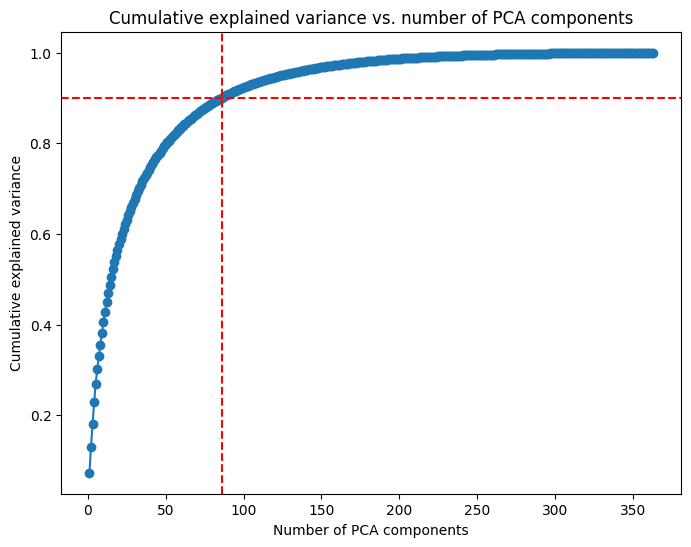

Optimale Anzahl der Komponenten, die mindestens 90% der Varianz erklären: 86


In [ ]:
# defining the components for 90% variance
# conduct pca
pca = PCA()
pca.fit(features)

# claculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# plot cumulative variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative explained variance vs. number of PCA components')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='--')  # Beispiel: 90% der Varianz
plt.axvline(x=np.argmax(cumulative_variance >= 0.90) + 1, color='r', linestyle='--')  # Marker für 90% Varianz
plt.show()

# Optimal number of components that explain at least 90% of the variance
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Optimale Anzahl der Komponenten, die mindestens 90% der Varianz erklären: {optimal_components}")

In [ ]:
# Dimensionsreduction with PCA and UMAP
pca = PCA(n_components=optimal_components)  # Automatically adjusts the number of components based on data
umap = UMAP(n_components=5, random_state=42)
reduced_vectors = pca.fit_transform(features)
final_vectors = umap.fit_transform(reduced_vectors)

In [ ]:
# Hierarchischal Clustering
cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0.3, linkage='ward')
cluster.fit(final_vectors)

labels = cluster.labels_

## Quality Check of Clusters

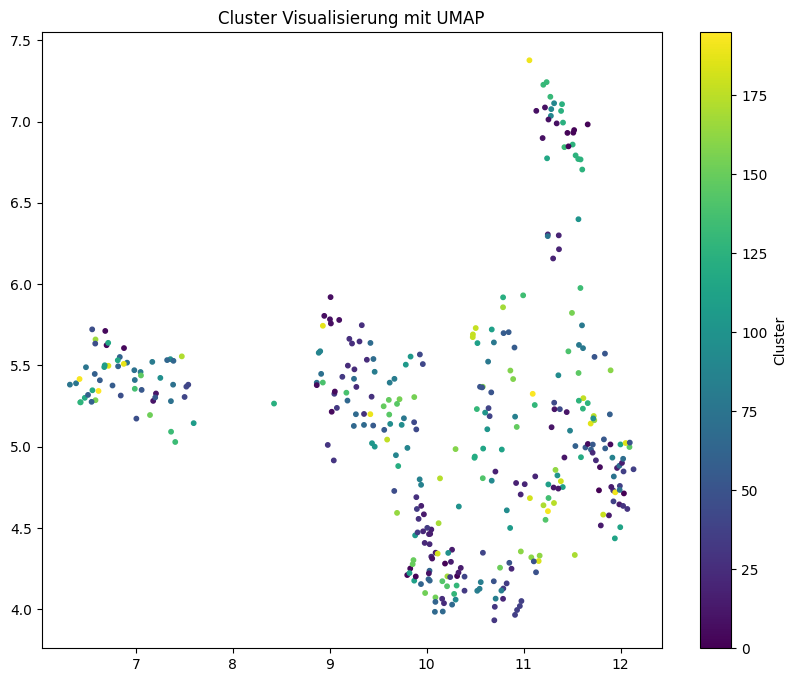

In [ ]:
# UMAP cluster visualisation for quality check of clustering
plt.figure(figsize=(10, 8))
plt.scatter(final_vectors[:, 0], final_vectors[:, 1], c=labels, cmap='viridis', s=10)
plt.title('Cluster Visualisierung mit UMAP')
plt.colorbar(label='Cluster')
plt.show()

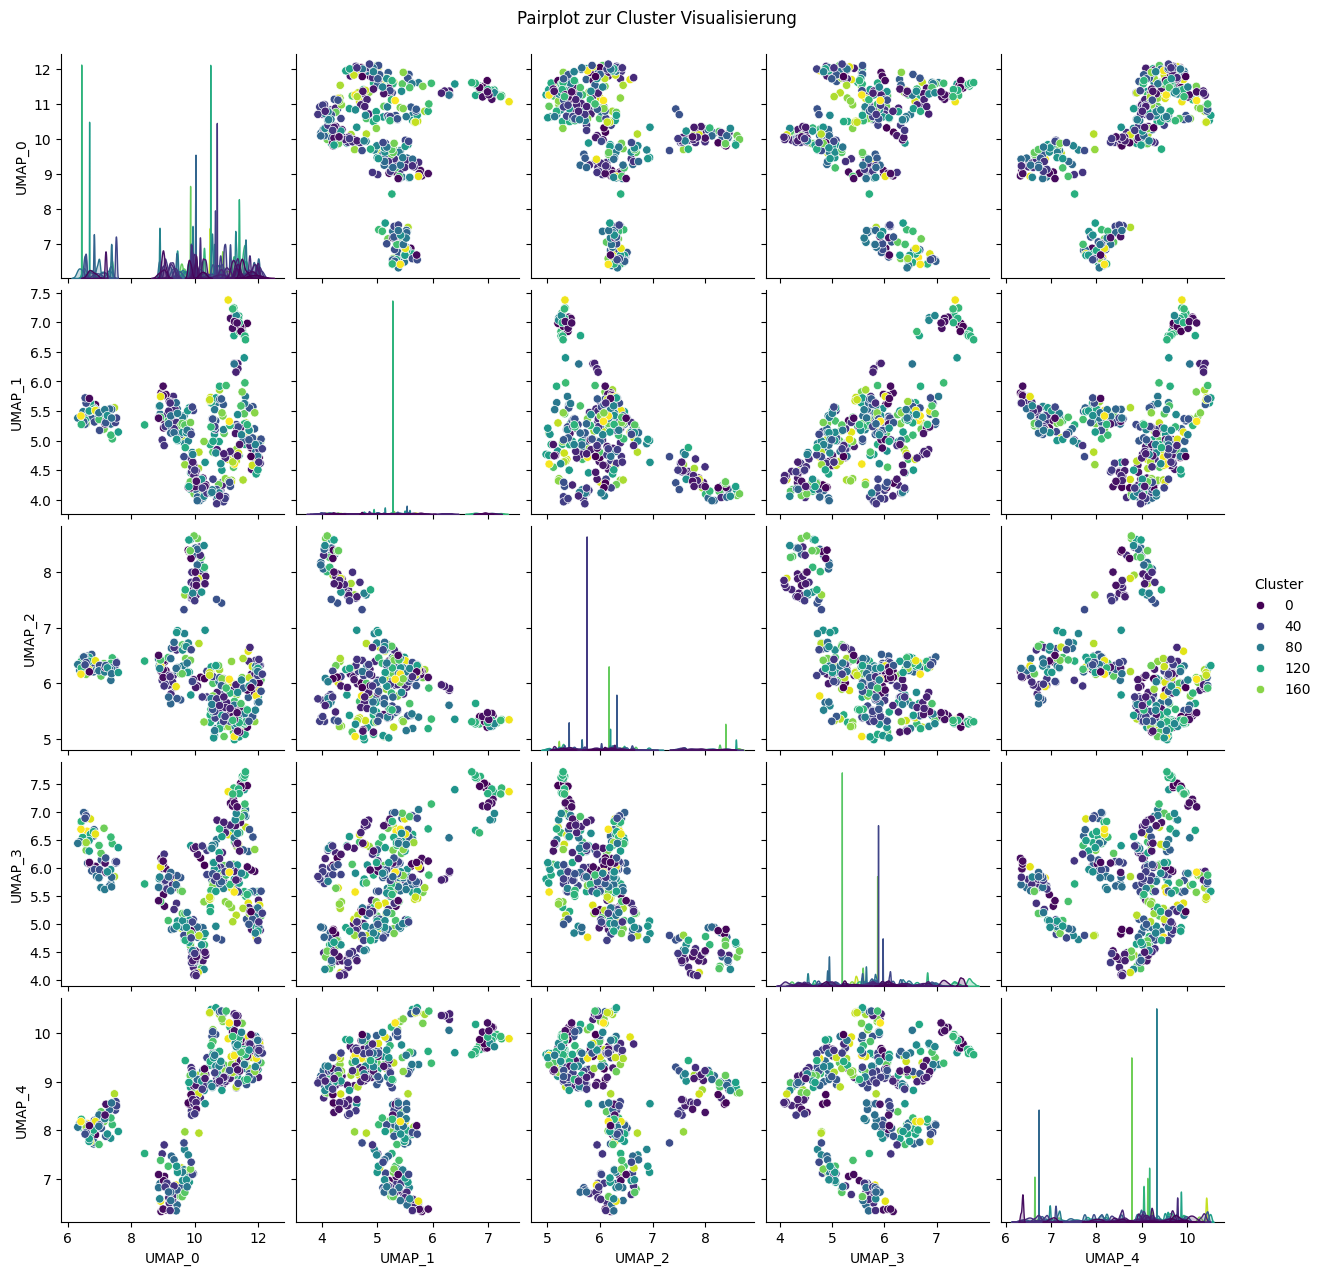

In [ ]:
df = pd.DataFrame(final_vectors, columns=[f"UMAP_{i}" for i in range(final_vectors.shape[1])])
df['Cluster'] = labels

# Pairplot to visualize 5 dimensions
sns.pairplot(df, hue='Cluster', palette='viridis')
plt.suptitle('Pairplot zur Cluster Visualisierung', y=1.02)
plt.show()

# Step 3: Hybrid Codebook Review

In this step, we iteratively review the clusters to construct a refined codebook. We compare each cluster against a preliminary codebook created by researchers. If no appropriate code exists, a new one is generated and added.

**Activities:**

-	Load and embed a preliminary codebook defined by researchers at Voicy AG
-	Compare each cluster of codes with the current codebook
-	For each cluster:
  - Assign to an existing code if suitable
  - Otherwise, generate a new code and add it to the codebook (incl. embedding)
  - Include a brief code description for transparency


**Output:**

A finalized, non-redundant codebook with definitions, and a consistent assignment of all quotes/clusters to appropriate codes. Therefore, for each quote there is a streamlined code.  

## Load Codebook

In this step, a minimal initial codebook is loaded, which was developed by the researchers as part of the research design. This preliminary set of codes reflects anticipated categories based on theoretical considerations or expected patterns in the data. Alternatively, an initial codebook can be generated automatically using a large language model (LLM), as demonstrated in Katz et al. (2025), where inductive coding was applied to create context-specific codes directly from the dataset.


In [ ]:
# load preliminary codebook
df_codebook = pd.read_csv("initial_codebook.csv")

In [ ]:
# embedd codebook
df_codebook["code_embedding"] = df_codebook["code"].astype(str).apply(lambda x: model.encode(instruct_prompt(x, task_code), normalize_embeddings=True))

task_desc = "Compare code descriptions in English."
df_codebook["description_embedding"] = df_codebook["code_description"].astype(str).apply(lambda x: model.encode(instruct_prompt(x, task_desc), normalize_embeddings=True))

In [ ]:
df_codebook

,code,code_description,code_embedding,description_embedding
0,Finding Joy at Work,"Experiencing joy and passion for one’s tasks, ...","[0.0012147243, 0.017595485, -0.036245566, -0.0...","[0.018802859, -0.00089953025, -0.0042196964, -..."
1,Demonstrating Self-Confidence,The belief in one’s ability to perform tasks a...,"[0.0046831123, 0.026896091, -0.030336505, -0.0...","[0.011780836, 0.018678514, -0.0065145614, -0.0..."
2,Feeling Trusted by Others,Experiencing trust from colleagues or superior...,"[0.025873426, 0.036532313, -0.04410395, -0.047...","[0.021743236, 0.028292654, -0.019068077, -0.04..."
3,Communicating Effectively,"Ability to listen attentively, communicate cle...","[0.023286875, 0.017439129, -0.016205635, -0.04...","[0.021935573, 0.0068274806, 0.0044839843, -0.0..."
4,Making Confident Decisions,"Capacity to make well-founded decisions, inclu...","[0.016709726, 0.018917223, -0.039914288, -0.02...","[0.023673132, 0.017988198, -0.0061096884, -0.0..."
5,Adapting to Change,Willingness and ability to adapt to new or une...,"[0.016164279, 0.013252896, -0.03151198, -0.035...","[-0.0051040067, 0.0006668781, -0.005032319, -0..."
6,Clarifying Responsibilities and Roles in Organ...,Having a clear understanding of one’s responsi...,"[0.033473413, 0.011950591, -0.04093815, -0.040...","[0.027987065, 0.014362833, -0.019507106, -0.04..."
7,Fostering Positive Relationships at Work,"Having supportive, meaningful, and energizing ...","[0.02561413, 0.009949299, -0.0405399, -0.02779...","[0.03448848, 0.030947646, -0.0069482815, -0.03..."
8,Feeling Appreciated,Feeling valued and recognized by others or one...,"[0.020941924, 0.03208359, -0.036085628, -0.037...","[0.0131891575, 0.03363097, -0.0049671945, -0.0..."
9,Being Optimistic,Having a generally positive outlook and believ...,"[0.0055273166, 0.0068031955, -0.027014192, -0....","[-0.0055827075, -0.0035197698, -0.00915728, -0..."


## JSON Schema

In [ ]:
class CodeDetails(BaseModel):
    generate_new_code: bool = Field(..., description="Indicates whether to create a new code (true) or not (false).", title = "generate_new_code")
    code: str = Field(..., description="The code label (either existing or new).", title = "code")
    description_code: str = Field(..., description="A concise description or definition of the code.", title = "description_code")
    justification_code: str = Field(..., description="Explanation of why this code is appropriate or needed.", title = "justification_code")

    class Config:
        extra = "forbid"

class CodeDefinition(BaseModel):
    code_item: CodeDetails = Field(..., description="Object with all information to the code", title = "code_item")

    class Config:
        extra = "forbid"

In [ ]:
# generate JSON schema
schema = CodeDefinition.model_json_schema()

# JSON schema for LLMs
json_schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "code_definition",
        "strict": False,
        "schema": schema
    }
}

print(json.dumps(json_schema, indent=4))

{
    "type": "json_schema",
    "json_schema": {
        "name": "code_definition",
        "strict": false,
        "schema": {
            "$defs": {
                "CodeDetails": {
                    "additionalProperties": false,
                    "properties": {
                        "generate_new_code": {
                            "description": "Indicates whether to create a new code (true) or not (false).",
                            "title": "generate_new_code",
                            "type": "boolean"
                        },
                        "code": {
                            "description": "The code label (either existing or new).",
                            "title": "code",
                            "type": "string"
                        },
                        "description_code": {
                            "description": "A concise description or definition of the code.",
                            "title": "description_code",
     

## Prompts

In [ ]:
system_prompt = """
You are an expert in inductive thematic analysis focusing on refining or creating codes based on the given initial codes.
Your role is to check if existing codes in the initial codebook apply to the data or if new codes are needed. Only add new codes if they are REALLY needed and distinct to existing codes.
ONLY respond in the correct JSON format and always use " to format the JSONs!
"""

In [ ]:
user_prompt = f"""
You are tasked with analyzing reflections from {reflectors} at {organisation}, with the goal of {goal}.
At this stage, you are provided with a set of initial codes, and your task is to assess whether these can be accurately represented by the existing codebook.

The purpose is to build a lean, actionable codebook that captures behavioral patterns and generalizable insights.

# Context

- These reflections highlight strengths, weaknesses, learnings, and aspirations from {reflectors} at {organisation}.
- Initial codes have already been clustered semantically. You now assess if each cluster fits into an existing code from the codebook.

# Your Role

You act as a **conservative reviewer**. Treat new code creation as a last resort — only do it if:
- An initial code clearly introduces a **new generalizable behavioral pattern**,
- And **cannot** reasonably be expressed with any existing code.

# Task Instructions

**Step 1**: Read the existing codebook (in <existing codebook>).

- You are only shown the top 5 semantically most similar codes from the full codebook, not the full set.

**Step 2**: Read all inital codes and their descriptions (in <codes to analyze>).

**Step 3**: Map the inital codes to any existing code if suitable.

- If a match is found, set `"generate_new_code": false` and return the matched `code` and `description` **verbatim** from the existing codebook.

**Step 4**: Propose a new code only if absolutely necessary, and set "generate_new_code": true.

- You should only create a new code if none of the provided codes adequately represent the meaning of the initial input.
- If you propose a new code without a strong justification, it will be treated as an error.
- If creating a new code, set `generate_new_code` to `true`, and provide:
    - `code`: A concise, action-oriented label describing a generalizable behavior or process. Make sure the new code operates on the same abstraction level as existing codes.
    - `description`: A brief, clear explanation of the behavior or pattern the code captures
    - `justification`: Why a new code is needed and how it differs from existing ones.
- Codes should reflect reusable insights or behavioral principles — not isolated examples or context-specific phrasing.
    - Too specific: 'Enhancing Team Dynamics through Shared Experiences', better: 'Strong team cohesion and sense of community'

**Step 5**: Consistency check:

- Ensure all codes are distinct and on a comparable abstraction level.
- Avoid synonymous or overlapping formulations.

**Step 6**: Output the valid JSON with all information as described.

- Provide only one code in your JSON response. If multiple codes seem appropriate, select the most fitting one.

# Example
You can use this example below as guide.

## Sample Input

Codebook with codes and their descriptions:

- Trust-based leadership fosters engagement: Leaders who exude trust and provide support enhance employee motivation and commitment.
- Lack of feedback and recognition lowers motivation: A lack of appreciation and feedback hinders motivation and reduces employee engagement.
- Commitment to improving teamwork: Employees aim to invest more time in improving teamwork.
- Clear structures and processes increase efficiency: Transparent workflows and clear guidelines help employees utilize their strengths effectively and work efficiently.

Initial codes and their descriptions:

- Empowering leadership through trust and freedom: Reflection on the importance of creating an environment where employees feel trusted and free to develop. The leader emphasizes the significance of not being perceived as controlling but rather as a coach who fosters growth and dynamism within the organization. This approach is seen as essential for employee satisfaction and engagement, contributing to a positive workplace atmosphere.
- Balancing ambition with supportive leadership: Discussion on the challenge of balancing the desire for success with the need to provide support and freedom to team members. The leader acknowledges their ambition and the importance of achieving goals while also fostering a collaborative and enjoyable work environment. This dual focus is seen as a key aspect of effective leadership.
- Strengthening the value of collegiality in leadership: Reflection on the importance of collegiality in leadership, emphasizing that success does not require a military approach but rather a leadership style that fosters collaboration. This realization has strengthened the belief in leading intuitively and effectively, highlighting the ability to connect with people and projects beyond traditional management methods.

## Sample JSON Output
```json
{{
  "code_item": {{
    "generate_new_code": false,
    "code": "Trust-based leadership fosters engagement",
    "code_description": "Leaders who exude trust and provide support enhance employee motivation and commitment.",
    "justification_code": "The existing code Trust-based leadership fosters engagement already captures the core theme of the analyzed data. The provided quote emphasizes the role of trust in leadership, the creation of an environment where employees feel free to develop, and the importance of support over control—all of which align with this code’s definition."
  }}
}}```


# Input data structure

Use the exact tags <existing codebook> and <codes to analyze> in your final input. Ensure the JSON keys appear in exactly the order required by the schema.

Existing codebook format:

- Existing Code: Description of the code

Codes to analyze format:

- Initial Code: Description of the code

# Data to analyse

"""

In [ ]:
# Function to get top codes to send the LLM to choose from
def get_top_codes(
        code_embs,             # List[np.ndarray] – Embeddings of the individual initial codes
        desc_embs,             # List[np.ndarray] – Embeddings of the initial code descriptions
        df_codebook,           # DataFrame with columns: code, code_embedding, description_embedding
        top_n_each=5           # Number of top matching codes to retrieve per initial code
    ):
    """Performs top-N voting across initial codes and returns the most frequently selected codes."""

    if not code_embs or not desc_embs or df_codebook.empty:
        return []

    # --- Prepare codebook ----------------------------------------------
    codebook_emb = np.vstack(df_codebook["code_embedding"])
    descbook_emb = np.vstack(df_codebook["description_embedding"])
    codebook_mat = (codebook_emb + descbook_emb) / 2  # Average of code and description embeddings

    # --- Prepare top-N voting ------------------------------------------
    votes = []

    for code_emb, desc_emb in zip(code_embs, desc_embs):
        # Single initial code embedding
        summary_emb = (np.array(code_emb) + np.array(desc_emb)) / 2
        summary_emb = summary_emb.reshape(1, -1)  # reshape to (1, dim) for similarity computation

        # Compute cosine similarity with all codebook entries
        sim_scores = cosine_similarity(codebook_mat, summary_emb).flatten()

        # Get top-N most similar codes
        best_indices = np.argsort(sim_scores)[::-1][:top_n_each]
        top_codes = df_codebook.iloc[best_indices]["code"].tolist()
        votes.extend(top_codes)

    # --- Evaluate voting -----------------------------------------------
    counter = Counter(votes)
    # Sort codes by frequency
    sorted_codes = [code for code, _ in counter.most_common()]

    return sorted_codes

In [ ]:
# Example ChatGPT: Function to generate initial codes
def call_gpt(system_prompt, user_message):
    """Sends a request to GPT to find or create codes and returns the response as JSON."""
    response = client.chat.completions.create(
        model="gpt-4o", #tbd
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt + user_message}
        ],
        response_format= json_schema,
        temperature=0.0,
    )

    return json.loads(response.choices[0].message.content.strip())

In [ ]:
# Example ChatGPT: loop to send top codes and enhance the codebook

data["code"] = np.nan
data["code_description"] = np.nan

gpt_logs = []

for cluster_value in number_clusters:
    cluster_summaries = data[data['cluster'] == cluster_value]['code_embedding'].tolist()

    # Find the top 5 most similar codes from the existing codebook
    top_codes = get_top_codes(cluster_summaries, df_codebook)
    codes_descriptions = df_codebook[df_codebook['code'].isin(top_codes)][['code', 'code_description']].to_dict(orient="records")

    # Format the top codes and descriptions as a bullet list
    formatted_codes = "\n".join([f"- {item['code']}: {item['code_description']}" for item in codes_descriptions])

    # Format the initial codes (from the current cluster) as a bullet list
    formatted_summaries = "\n".join([f"- {row.initial_code}: {row.initial_code_description}" for row in data[data['cluster'] == cluster_value].itertuples(index=False)])

    # Create the user message prompt for GPT
    user_message = f""" \n\n
    <data to analyze>
    <existing codebook>
    {formatted_codes}
    </existing codebook>
    <codes to analyze>
    {formatted_summaries}
    </codes to analyze>
    </data to analyze>

    Act like an inductive Thematic Analysis researcher would when conducting this Inductive Thematic Analysis for
    generating the names of redined codes and their descriptions. You will be rewarded $1000 if you can complete this effectively.
    """

    # Call the GPT model with the system and user prompts
    gpt_response = call_gpt(system_prompt, user_message)

    # Extract the generated code from GPT’s response
    generated_code = gpt_response['code_item']['code']

    # Save GPT log data
    gpt_logs.append({
        "cluster": cluster_value,
        "generate_new_code": gpt_response['code_item']['generate_new_code'],
        "code": gpt_response['code_item']['code'],
        "code_description": gpt_response['code_item']['code_description'],
        "code_justification": gpt_response['code_item']['justification_code'],
        "was_new_code": generated_code not in df_codebook['code'].values,
        "full_response": gpt_response
    })

    # Check whether the code already exists in the codebook
    if generated_code not in df_codebook['code'].values:
        # If it does not exist, add it to the codebook (incl. embeddings)
        new_code_data = {
            "code": generated_code,
            "code_description": gpt_response['code_item']['code_description'],
            "code_embedding": model.encode(generated_code),
            "description_embedding": model.encode(gpt_response['code_item']['code_description'])
        }
        df_codebook = pd.concat([df_codebook, pd.DataFrame([new_code_data])], ignore_index=True)

    # Assign the final code and its description to all rows within the current cluster
    data.loc[data['cluster'] == cluster_value, 'code'] = gpt_response['code_item']['code']
    data.loc[data['cluster'] == cluster_value, 'code_description'] = gpt_response['code_item']['code_description']

# Save the coding log to file
df_coding_log = pd.DataFrame(gpt_logs)
df_coding_log.to_csv("20_coding_log.csv", index = False)

## Quality Check

Also in this step, the integrity and consistency of the data processed should be verified. First, we check for missing values or potential information loss, such as inconsistencies in participant identifiers. Second, we validate the alignment between the codebook and the generated data by ensuring that each code used in the data has a corresponding description in the codebook. This quality control step ensures that the analytical framework remains coherent and interpretable throughout the pipeline.

# Step 4: Emerging Theme Definition
In this final step, the goal is to identify overarching themes that capture broader patterns across the dataset. Themes synthesize and abstract meaning from individual codes, providing a higher-level structure for interpretation. This step is conducted in two phases: first, to generate overarching themes based on the existing codes and their descriptions; second, to ensure that each identified code is consistently assigned to one of these themes. Each code must be mapped to exactly one theme to maintain a clear and non-redundant thematic structure.


**Activities:**

-	Theme generation phase: generation of overarching themes
  - Send all finalized codes, their descriptions, and representative quotes to the LLM
  - Prompt the LLM to generate up to 10 major themes and their descriptions
-	Theme refinement phase: ensuring all codes have corresponding theme
  - Reassign each cluster of codes from Step 2 to the best-fitting theme



**Output:**

A set of up to 10 overarching themes (plus an additional theme labelled “Others” if necessary) each with a clear name, definition, and a list of assigned sub-codes. As a result, each quote in the dataset is now assigned its corresponding attributes, a refined code, and an overarching theme.

*Note: Especially the results generated in this step showed limited alignment with the human-coded reference data. This suggests that the current implementation may require further refinement to reach the level of abstraction and thematic coherence achieved by manual analysis.*

## Prepare Input Data for Prompt

In [ ]:
# prepare data to send: all codes, sub-codes and code descriptions

# List to store dictionaries for each codebook entry
all_code_entries = []

for _, row in df_codebook_new.iterrows():
    main_code = row["code"]
    main_desc = row["code_description"]

    # Find all matching sub-codes (column "Code") from df_data
    # where 'assigned_code' matches the main_code
    matching_data = data[data["code"] == main_code]

    # Get up to 10 unique sub-codes
    sub_codes = matching_data["initial_code"].unique()[:10].tolist()

    # Create a JSON-compatible dictionary
    code_entry = {
        "code": main_code,
        "code_description": main_desc,
        "inital_codes": sub_codes
    }

    # Add the dictionary to the list
    all_code_entries.append(code_entry)

# Convert the list to JSON format
json_input_data = json.dumps(all_code_entries, indent=4, ensure_ascii=False)

print(json_input_data)

In [ ]:
number_codes = df_codebook_new["code"].nunique()
number_codes

58

## JSON Schema - Theme Generation Phase

In [ ]:
class ThemeDetails(BaseModel):
    theme_name: str = Field(..., description="The name for the overarching theme based on the existing codes.", title = "theme_name")
    theme_description: str = Field(..., description="A concise description or definition of the theme.", title = "theme_description")
    codes: List[str] = Field(..., description="A list of the codes belonging to the theme, where each code is a string.", title = "codes")
    theme_justification: str = Field(..., description="Explanation of why this theme was created and the corresponding codes are suitable.", title = "theme_justification")

In [ ]:
# generate JSON schema
schema = ThemeDetails.model_json_schema()

# JSON schema for LLMs
json_schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "theme_definition",
        "strict": False,
        "schema": schema
    }
}

print(json.dumps(json_schema, indent=4))

{
    "type": "json_schema",
    "json_schema": {
        "name": "theme_definition",
        "strict": false,
        "schema": {
            "$defs": {
                "ThemeDetails": {
                    "properties": {
                        "theme_name": {
                            "description": "The name for the overarching theme based on the existing codes.",
                            "title": "theme_name",
                            "type": "string"
                        },
                        "theme_description": {
                            "description": "A concise description or definition of the theme.",
                            "title": "theme_description",
                            "type": "string"
                        },
                        "codes": {
                            "description": "A list of the codes belonging to the theme, where each code is a string.",
                            "items": {
                                "type

## Prompts - Theme Generation Phase

In [ ]:
system_prompt = f"""
You are an expert in inductive thematic analysis focusing on the theme generation stage. You are provided refined codes, with their descriptions and initial codes under them.
Your role is to create a final codebook with major themes based on the exisitng codes. Make sure to map each of the {number_codes} unique codes to a theme.
Always follow the provided task instructions and output only valid JSON according to the JSON schema.
"""

In [ ]:
example = """

# Example

Here is an example, which you can use as a guide.

## Input JSON (Synthetical Example)

```json
[
    {
        "code": "Effective Communication Enhances Productivity",
        "code_description": "Clear and open communication channels improve team productivity and reduce misunderstandings.",
        "inital_codes": [
            "Regular team meetings improve project coordination",
            "Transparent communication builds trust",
            "Feedback sessions enhance performance",
            "Use of digital tools for efficient communication",
            "Open dialogue resolves conflicts quickly",
            "Importance of clear instructions in task delegation",
            "Active listening skills in team interactions",
            "Regular updates on project progress",
            "Challenges with miscommunication in remote teams",
            "Impact of language barriers on team communication"
        ]
    },
    {
        "code": "Innovative Training Programs Boost Skills",
        "code_description": "Innovative training programs help employees develop new skills and stay updated with industry trends.",
        "inital_codes": [
            "Workshops on emerging technologies",
            "Mentorship programs for new employees",
            "Online courses for continuous learning",
            "Hands-on training sessions",
            "Guest lectures from industry experts",
            "Role-playing exercises for skill development",
            "Feedback from training participants",
            "Impact of training on employee confidence",
            "Challenges in implementing new training methods",
            "Benefits of blended learning approaches"
        ]
    },
    {
        "code": "Employee Well-being Improves Performance",
        "code_description": "Initiatives focused on employee well-being lead to better performance and job satisfaction.",
        "inital_codes": [
            "Mental health support programs",
            "Flexible work hours for better work-life balance",
            "Wellness activities and workshops",
            "Healthy snacks and meals at the workplace",
            "Employee assistance programs",
            "Regular check-ins on employee well-being",
            "Impact of stress on productivity",
            "Benefits of physical activity on mental health",
            "Challenges in implementing well-being initiatives",
            "Employee feedback on well-being programs"
        ]
    },
    {
        "code": "Leadership Development Strengthens Teams",
        "code_description": "Leadership development programs equip leaders with the skills to guide and motivate their teams effectively.",
        "inital_codes": [
            "Leadership coaching and mentoring",
            "Workshops on effective communication for leaders",
            "Training on conflict resolution",
            "Importance of emotional intelligence in leadership",
            "Feedback from team members on leadership styles",
            "Impact of leadership on team morale",
            "Challenges faced by new leaders",
            "Benefits of diverse leadership styles",
            "Leadership development plans",
            "Role of leaders in fostering innovation"
        ]
    },
    {
        "code": "Customer-Centric Approach Drives Success",
        "code_description": "A focus on customer needs and feedback drives business success and customer satisfaction.",
        "inital_codes": [
            "Regular customer feedback collection",
            "Customer-focused product development",
            "Importance of customer service training",
            "Analyzing customer data for insights",
            "Personalized customer experiences",
            "Handling customer complaints effectively",
            "Customer loyalty programs",
            "Impact of customer satisfaction on business growth",
            "Challenges in meeting customer expectations",
            "Benefits of a customer-centric culture"
        ]
    },
    {
        "code": "Lack of Resources Hinders Progress",
        "code_description": "Insufficient resources can slow down projects and demotivate employees.",
        "inital_codes": [
            "Impact of budget cuts on project timelines",
            "Challenges in acquiring necessary tools and equipment",
            "Limited access to training and development opportunities",
            "Insufficient staffing levels",
            "Difficulty in securing project funding",
            "Impact of resource constraints on employee morale",
            "Strategies for optimizing available resources",
            "Importance of resource planning",
            "Feedback from employees on resource allocation",
            "Benefits of investing in resources"
        ]
    },
    {
        "code": "Commitment to Sustainability",
        "code_description": "A commitment to sustainability practices benefits the environment and the organization's reputation.",
        "inital_codes": [
            "Implementing eco-friendly practices in the workplace",
            "Reducing carbon footprint",
            "Sustainable procurement policies",
            "Employee engagement in sustainability initiatives",
            "Benefits of sustainability on cost savings",
            "Challenges in adopting sustainable practices",
            "Customer perception of sustainability efforts",
            "Impact of sustainability on brand image",
            "Feedback from stakeholders on sustainability initiatives",
            "Long-term benefits of sustainability"
        ]
    },
    {
        "code": "Potential for Digital Transformation",
        "code_description": "Employees see potential in digital transformation to improve efficiency and innovation.",
        "inital_codes": [
            "Adoption of new technologies",
            "Automation of repetitive tasks",
            "Data-driven decision-making",
            "Impact of digital transformation on customer experience",
            "Challenges in digital adoption",
            "Benefits of digital tools in collaboration",
            "Training on digital skills",
            "Feedback from employees on digital initiatives",
            "Importance of cybersecurity in digital transformation",
            "Long-term benefits of digital transformation"
        ]
    },
    {
        "code": "Better Work-Life Balance Increases Well-being",
        "code_description": "There is potential to further improve work-life balance on both team and individual levels.",
        "inital_codes": [
            "Flexible work arrangements",
            "Support for remote work",
            "Encouraging hobbies and personal interests",
            "Importance of regular breaks",
            "Impact of work-life balance on productivity",
            "Challenges in maintaining work-life balance",
            "Feedback from employees on work-life balance initiatives",
            "Benefits of a balanced lifestyle",
            "Strategies for achieving work-life balance",
            "Long-term benefits of work-life balance"
        ]
    },
    {
        "code": "Customer and Employee Engagement Increases Value",
        "code_description": "Employees recognize the need to continue investing more time and resources in targeted customer and employee engagement.",
        "inital_codes": [
            "Importance of employee engagement in productivity",
            "Customer engagement strategies",
            "Feedback from customers and employees",
            "Impact of engagement on business growth",
            "Challenges in maintaining engagement",
            "Benefits of engaged customers and employees",
            "Strategies for improving engagement",
            "Long-term benefits of engagement",
            "Role of leadership in fostering engagement",
            "Importance of recognition in engagement"
        ]
    },
    {
        "code": "Celebrating Achievements Fosters Community",
        "code_description": "Recognizing and celebrating achievements fosters a sense of community and shared success among staff and customers, contributing to a positive organizational culture.",
        "inital_codes": [
            "Celebrating team achievements",
            "Recognition of individual contributions",
            "Impact of celebrations on morale",
            "Importance of authentic recognition",
            "Feedback from employees on recognition programs",
            "Benefits of a positive organizational culture",
            "Strategies for celebrating achievements",
            "Long-term benefits of recognition",
            "Role of leadership in celebrating achievements",
            "Importance of inclusivity in celebrations"
        ]
    }
]
```

## Expected Output (synthetical example)

```json
{
  "themes_list": [
    {
      "theme_name": "Enhancing Communication and Collaboration",
      "theme_description": "Effective communication and collaboration are essential for improving productivity and team cohesion.",
      "codes": [
        "Effective Communication Enhances Productivity",
        "Commitment to Sustainability"
      ],
      "theme_justification": "Both codes emphasize the importance of clear communication and collaborative efforts in achieving organizational goals and fostering a positive work environment."
    },
    {
      "theme_name": "Developing Leadership and Employee Skills",
      "theme_description": "Leadership development and continuous learning contribute to a skilled and motivated workforce.",
      "codes": [
        "Innovative Training Programs Boost Skills",
        "Leadership Development Strengthens Teams"
      ],
      "theme_justification": "These codes focus on the role of training and leadership development in enhancing employee skills and driving organizational success."
    },
    {
      "theme_name": "Improving Employee Well-being and Engagement",
      "theme_description": "Initiatives focused on employee well-being and engagement are crucial for maintaining motivation and job satisfaction.",
      "codes": [
        "Employee Well-being Improves Performance",
        "Customer and Employee Engagement Increases Value"
      ],
      "theme_justification": "These themes address the importance of well-being programs and engagement strategies in fostering a positive and productive work environment."
    },
    {
      "theme_name": "Driving Innovation and Digital Transformation",
      "theme_description": "Innovation and digital transformation drive efficiency, customer satisfaction, and long-term success.",
      "codes": [
        "Potential for Digital Transformation",
        "Customer-Centric Approach Drives Success"
      ],
      "theme_justification": "This theme captures the organization's focus on leveraging technology and customer feedback to drive progress and innovation."
    },
    {
      "theme_name": "Balancing Work and Life for Employee Well-being",
      "theme_description": "Maintaining a balance between work and personal life enhances job satisfaction and overall well-being.",
      "codes": [
        "Better Work-Life Balance Increases Well-being",
        "Celebrating Achievements Fosters Community"
      ],
      "theme_justification": "This theme highlights the need for work-life balance and the importance of celebrating achievements for motivation and community building."
    }
  ]
}
```


"""

In [ ]:
user_prompt = f"""
You will be provided grouped codes with more detailed initial codes generated from reflections of {reflectors} at {organisation}, targeting to {goal}.
You review these provided codes and their initial codes to generate maximum 10 major overarching themes. Each code must be assigned to exactly one overarching theme. It is important to list each code clearly under its respective theme.

# Context

- These reflections highlight strengths, weaknesses, learnings, and aspirations from {reflectors} at {organisation}.
- The ultimate aim is to maximal 10 distinct themes with descriptions and the corresponding codes beneath.

# Task Instructions

**Step 1**: Read the existing codes, their descriptions and their initial codes.

**Step 2**: Define maximal 10 overarching themes, which emerge from the provided codes, their descriptions and initial codes.

- The name of the themes are strengths, weaknesses, learnings and aspirations for {organisation}.
- An overarching theme needs formulated in an active way, not only a single word.
- Define a description for every overarching theme.

**Step 3**: Map the provided codes to a theme.

- Important: Every provided code, needs a overarching theme.
- If you cannot place a code in an existing theme, define the theme as ‘Other’. Omission of any code is not permitted.
- Each code must be assigned to exactly one theme. A code cannot appear in more than one theme.

**Step 4**: Review your defined overarching themes and make sure, they are distinct and there are no redundancies.

- Ensure that each of the {number_codes} unique codes is assigned to an overarching theme. Every code must be included without exception!

**Step 5**: Output all themes, descriptions and the corresponding codes in the defined JSON.

{example}

# Data to analyse

Here you can find each code, their descriptions and their initial codes in JSON format to do your analysis:

{json_input_data}

"""

In [ ]:
# Example ChatGPT: sending prompt via API
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ],
    response_format= json_schema,
    temperature=0.0,
)

## JSON Schema - Theme Refinement Phase

In [ ]:
#save all possible theme names for enum restriciton based on feedback from API call above
theme_names = df_themes["theme_name"].tolist() + ["others"]

class ThemeAssignment(BaseModel):
    theme_name: Literal[*theme_names] = Field(..., title="theme_name", description="Name of the theme based on the existing themes or 'others' if no match.")
    theme_justification: str = Field(..., title="theme_justification", description="Dense justification, why this theme is best fitting.")


In [ ]:
# generate JSON schema
schema = ThemeAssignment.model_json_schema()

# JSON schema for LLMs
json_schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "theme_assignment",
        "strict": False,
        "schema": schema
    }
}

print(json.dumps(json_schema, indent=4))

{
    "type": "json_schema",
    "json_schema": {
        "name": "theme_assignment",
        "strict": false,
        "schema": {
            "$defs": {
                "SummaryItem": {
                    "properties": {
                        "Theme-Name": {
                            "description": "Name of the theme based on the existing themes or 'others' if no match.",
                            "enum": [
                                "Communication",
                                "Leadership",
                                "Collaboration",
                                "others"
                            ],
                            "title": "Theme-Name",
                            "type": "string"
                        },
                        "Theme-Justification": {
                            "description": "Dense justification, why this theme is best fitting.",
                            "title": "Theme-Justification",
                            "type"

## Prompts - Theme Refinement Phase

In [ ]:
# prepare data to send: all codes, sub-codes and code descriptions

# List to store dictionaries for each codebook entry
all_code_entries = []

for _, row in df_themes.iterrows():
    main_code = row["theme_name"]
    main_desc = row["theme_description"]

    # Create a JSON-compatible dictionary
    code_entry = {
        "theme_name": main_code,
        "theme_description": main_desc,
    }

    # Add the dictionary to the list
    all_code_entries.append(code_entry)

# Convert the list to JSON format
all_themes = json.dumps(all_code_entries, indent=4, ensure_ascii=False)

print(all_themes)

In [ ]:
system_prompt = f"""
You are an expert in inductive thematic analysis focusing on the theme-generation stage.
You have a set of existing overarching themes. You will be given one code, its description, and its relevant initial codes.
Your job: determine which one of these overarching themes best fits the code.
You must assign exactly one theme per code.
If no existing theme fits, choose "others".
Output must be valid JSON that conforms strictly to the provided JSON schema.
"""

In [ ]:
example = """

# Example

Here is an example, which you can use as a guide.

## Input Data

main_code: Team cohesion strengthens collaboration

code_description: Employees experience team cohesion as valuable and motivating. Shared experiences promote exchange and a sense of unity.

initial codes:
- Leadership workshop fosters team bonding and skills
- Collaborative teamwork with direct supervisor
- Positive team collaboration during international events
- Collaboration enhances understanding and teamwork
- Gratitude for collaborative efforts and teamwork

## Expected output:

```json{
      "theme_name": "Fostering Collaborative Environment",
      "theme_justification": "The theme emphasizes team cohesion, shared experiences, and mutual exchange—core aspects of fostering a collaborative environment aimed at enhancing teamwork, communication, and support."
}```

"""

In [ ]:
user_prompt = f"""
You will be provided a code with more detailed initial codes generated from reflections of {reflectors} at {organisation}, targeting to {goal}.

# Task Instructions

**Step 1**: Review the existing overarching themes in the <themes>-Tag and their descriptions.

**Step 2**: Read the code and its initial codes provided in the <data_to_analyse>-Tag.

**Step 3**: Assign the code to exactly one of the existing overarching themes.

- You must select only one theme.
- If no existing theme fits, choose "others".
- Do not assign the code to multiple themes under any circumstances.

**Step 4**: Output your result in valid JSON matching the given schema:

- The top-level output is an object containing an array `items`.
- Each item in `items` must have:
  1. `theme_name` – must be one of the listed themes or `others`.
  2. `theme_justification` – a concise reason for choosing that theme.


{example}


# Data to analyse

## Exiting overarching themes

<themes> {all_themes} </themes>

"""

In [ ]:
def get_codes_and_subcodes(row):
    main_code = row["code"]
    main_desc = row["code_description"]

    # Find all matching sub-codes (column "Code") from df_data
    # where 'assigned_code' matches the main_code
    matching_data = data[data["code"] == main_code]

    # Get up to 10 unique sub-codes
    sub_codes = matching_data["code"].unique()[:10].tolist()

    return main_code, main_desc, sub_codes


def process_row(row):
    main_code, main_desc, sub_codes = get_codes_and_subcodes(row)
    return get_themes(main_code, main_desc, sub_codes)

In [ ]:
# ChatGPT Example: Sending this prompt for each code in the codebook

# Function to assign final theme(s)
# Function to generate initial codes
def get_themes(code_name, code_description, sub_codes, retries=1):
    for attempt in range(retries + 1):
        # Send prompt to OpenAI API
        completion = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt + f"  \n\n <data_to_analyse> <main_code> {code_name} </main_code> <code_description> {code_description} </code_description> <initial codes> {sub_codes} </initial codes> </data_to_analyse> "}
                ],
                response_format=json_schema,
                temperature=0.0,
            )
        response = completion.choices[0].message.content
        json_response = json.loads(response)

        # Special case: the model returned the schema instead of a valid response
        if (
            isinstance(json_response, dict)
            and "properties" in json_response
            and "theme_name" in json_response["properties"]
        ):
            print("⚠️ Model returned the schema instead of a result – retrying...")
            continue  # try again

        # Normal response formats
        if "items" in json_response and isinstance(json_response["items"], list):
            print(json_response["items"][0])
            return json_response["items"][0]
        elif "theme_name" in json_response and "theme_justification" in json_response:
            print(json_response)
            return json_response
        else:
            raise ValueError("Unexpected format in JSON response.")

    raise RuntimeError("Multiple failed attempts – model keeps returning only the schema.")

## Quality Check

In the final step, we perform a consistency and completeness check of the output data. Specifically, we ensure that all initial codes and their associated quotes are still present, that each code has been assigned to a theme, and that every theme is accompanied by a descriptive label. Once these validations are complete, the structured results are exported and saved for subsequent analysis.

The final output data looks as following:

In [ ]:
data.head(1)

,Survey_ID,Person_ID,Response_ID,Date,Question,Answer,initial_code,initial_code_description,quote,level,category,code_embedding,code_desc_embedding,category_embedding,level_embedding,cluster,code,code_description,theme_name,theme_description
0,5b1c9a83-97d4-42b8-ab53-21130be446cb,1,e4717150-21ff-444e-8bef-39909273e5b8,2024-11-29,Welche Momente in diesem Jahr haben bei dir ei...,Wenn ich über das letzte Jahr nachdenke und am...,Strengthening team bonds through shared experi...,Reflection on the positive impact of team-buil...,Wenn ich über das letzte Jahr nachdenke und am...,group,strength,[ 0.00935839 0.0176871 -0.0166863 ... -0.00...,[ 0.02887953 0.01350927 -0.04438983 ... -0.01...,[ 0.0509526 0.04876133 -0.01521335 ... -0.00...,[ 0.03984372 0.0150655 -0.01373968 ... -0.01...,29,Enhancing Team Cohesion through Shared Experie...,The process of building stronger team bonds an...,Improving Communication and Collaboration,Fostering effective communication and collabor...
